### prueba de parametros skopt

### 0. Load Kedro context:
- This is only necessary to run a notebook within a Kedro project, not needed in production code when running nodes/pipelines

In [1]:
# Load kedro environment (not needed in .py)
from pathlib import Path
from kedro.framework.context import load_context

# Load a context to be able to work in the notebook
current_dir = Path("/u01/share/cesar/aa_engine_uy/notebooks/04_features")
#current_dir = Path.cwd()
proj_path = current_dir.parent.parent
context = load_context(proj_path)
catalog = context.catalog
credentials = context.config_loader.get("credentials*","credentials*/**")
parameters = context.config_loader.get("parameters*","parameters*/**")
from re import search
import random
from aa_engine_pkg.assets.utils import *
from aa_engine_pkg.assets.core.data.kedro.catalog_expansion.partitioned_sql import SQLPartitionedDataSet
from sklearn import model_selection
from functools import partial
from skopt import space
from skopt import gp_minimize

ModuleNotFoundError: No module named 'kedro'

In [2]:
# -------------------------------- UPSELL MODEL --------------------------------
# Using temporal division
# Initialize logger
log = initialize_logger()
log.info(f"[TRAIN_MODEL] Creating model...")

# Loading parameters
model = "upsell"
model_type = "binary"
if model == "":
    model = parameters["models"]["model"]
if model_type == "":
    model = parameters["models"][model]["model_type"]
model_path = parameters["paths"]["model_path"]
n_threads = parameters["models"]["n_threads"]

random_time=False
downsample=False

2021-03-26 12:38:07,429 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Creating model...


In [3]:
train_periods = parameters["models"][model][model_type]["train_periods"]
dev_periods = parameters["models"][model][model_type]["dev_periods"]
test_periods = parameters["models"][model][model_type]["test_periods"]
id_vars = parameters["models"][model][model_type]["id_vars"]
period_vars = parameters["models"][model][model_type]["period_vars"]
target_var = parameters["models"][model][model_type]["target_var"]
score_var = parameters["models"][model][model_type]["score_var"]
load_subsample = parameters["models"][model][model_type]["load_subsample"]
fill_na_with = parameters["models"][model][model_type]["fill_na_with"]

In [4]:
test_periods

['20200615', '20200713', '20200810', '20200907']

In [6]:
if type(fill_na_with) == str:
    fill_na_with = eval(fill_na_with)

# Join periods
model_periods = list(np.unique(train_periods + dev_periods))
if len(model_periods) < (len(train_periods) + len(dev_periods)):
    log.warning(f"Validation periods and train periods overlap")

# Set maximum number of threads
os.environ["NUMEXPR_MAX_THREADS"] = str(n_threads)

### 1. Random periods and downsample

In [5]:
#Random periods
if random_time == True:
    random.seed(4)
    l=train_periods+dev_periods+test_periods
    ix=list(range(len(l)-1))
    sampled_list = random.sample(ix, int(0.8*len(ix)))
    train_list = [l[i] for i in sampled_list ] 
    test_list = [l[i] for i in ix if i not in sampled_list ] 
else:
    train_list=train_periods+dev_periods
    test_list=test_periods
    
print(f"----------- train periods -------------")
print(f"{train_list}")
print(f"----------- test periods -------------")
print(f"{test_list}")

----------- train periods -------------
['20181203', '20181231', '20190128', '20190225', '20190325', '20190422', '20190520', '20190617', '20190715', '20190812', '20190909', '20191007', '20191104', '20191202', '20191230', '20200127', '20200224', '20200323', '20200420', '20200518']
----------- test periods -------------
['20200615', '20200713', '20200810', '20200907']


In [7]:
test_list

['20200615', '20200713', '20200810', '20200907']

In [8]:
#Downsample
ratio_noevents_vs_events=4
if downsample==True:
    random.seed(4)
    df_all = load_and_merge_tables(model=model,
                                     model_type=model_type,
                                     periods=train_list+test_list,
                                     parameters=parameters,
                                     load_subsample=load_subsample,
                                     load_target=True)
    df_all.reset_index(drop=True,inplace=True)
    df_down_sample=[]
    for date in df_all.DATE_CALC.unique():
        if date not in test_list:
            idx_target=df_all.loc[(df_all.TARGET==1) & (df_all.DATE_CALC==date)].index
            n_target=df_all.loc[(df_all.TARGET==1) & (df_all.DATE_CALC==date)].shape[0]

            idx_no_target=df_all.loc[(df_all.TARGET==0) & (df_all.DATE_CALC==date)].index
            n_no_target=df_all.loc[(df_all.TARGET==0) & (df_all.DATE_CALC==date)].shape[0]
            
            n=np.where(n_target*ratio_noevents_vs_events<n_no_target,n_target*ratio_noevents_vs_events,n_no_target)

            random_indices = np.random.choice( idx_no_target, n , replace=False)
            down_sample_indices = np.concatenate([idx_target,random_indices])
            aux=df_all.loc[down_sample_indices].copy()
            
            print(f"ratio 1/0 {date}: { np.round(aux.TARGET.mean(),2) }")
            df_down_sample.append(aux)

        df_down=pd.concat(df_down_sample)
        df_train=df_down.loc[df_down.DATE_CALC.isin(train_list)].copy()
        
    df_test=df_all.loc[df_all.DATE_CALC.isin(test_list)].copy()
else:
    print("-----------No downsample ------------------")
    # Load datasets
    df_train = load_and_merge_tables(model=model,
                                     model_type=model_type,
                                     periods=train_list,
                                     parameters=parameters,
                                     load_subsample=load_subsample,
                                     load_target=True)
    print(f"ratio 1/0 {df_train.groupby('DATE_CALC').agg({'TARGET':'mean'})}")
    df_test = load_and_merge_tables(model=model,
                                    model_type=model_type,
                                    periods=test_list,
                                    parameters=parameters,
                                    load_subsample=False,
                                    load_target=True)

print(f"ratio 1/0 {df_test.groupby('DATE_CALC').agg({'TARGET':'mean'})}")

-----------No downsample ------------------
2021-03-26 12:39:02,831 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20181203
2021-03-26 12:39:03,544 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20181231
2021-03-26 12:39:04,365 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190128
2021-03-26 12:39:05,122 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190225
2021-03-26 12:39:05,654 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190325
2021-03-26 12:39:06,200 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190422
2021-03-26 12:39:06,730 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190520
2021-03-26 12:39:07,338 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190617
2021-03-26 12:39:08,014 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190715
2021-03-26 12:39:08,780 - aa_engine_pkg.assets.utils.utilities - INFO - Loading 20190812
2021-03-26 12:39:09,630 - aa_engine_pkg.assets.utils.utilities - I

In [9]:
df_test.groupby("DATE_CALC").TARGET.sum()

DATE_CALC
20200615    150
20200713    124
20200810    191
20200907    150
Name: TARGET, dtype: int32

### 2. Split

In [11]:
# Split train and dev sets
X_train, X_dev, y_train, y_dev = model_pipeline.create_train_test_datasets(df_train, df_train[target_var], test_size=0.2)
df_train = X_train
df_train[target_var] = y_train
df_dev = X_dev
df_dev[target_var] = y_dev
del X_train, y_train, X_dev, y_dev; gc.collect()

if model_type == "binary":
    for df, name in zip([df_train, df_dev, df_test], ["TRAIN", "DEV", "TEST"]):
        log.info(f"{name}:")
        log.info(pd.crosstab(df["DATE_CALC"], df["TARGET"]).reset_index().apply(lambda x: x[1] / (x[1] + x[0]),axis=1))
            
elif model_type == "multiclass":
    for df, name in zip([df_train, df_dev, df_test], ["TRAIN", "DEV", "TEST"]):
        for idx, cat in enumerate(df[target_var].unique()):
            log.info(f"{name}:")
            log.info(f"{cat}:")
            log.info(pd.crosstab(df["DATE_CALC"], df[target_var]).apply(lambda x: x[idx] / (x[0] + x[1] + x[2]), axis=1))

# Exclude vars
vars_to_exclude = []
num_vars = df_train.select_dtypes(include=[np.number]).columns.tolist()

# Select vars to use for training
vars_to_model = list(set(num_vars) - set(id_vars + period_vars + [target_var] + vars_to_exclude))

del df; gc.collect()

df_dev = add_selected_variables(df_dev, vars_to_model, fill_na_with)
df_test = add_selected_variables(df_test, vars_to_model, fill_na_with)

2021-03-26 12:42:31,512 - aa_engine_pkg.assets.utils.utilities - INFO - TRAIN:
2021-03-26 12:42:31,556 - aa_engine_pkg.assets.utils.utilities - INFO - 0     0.006639
1     0.007883
2     0.008115
3     0.009058
4     0.007719
5     0.006651
6     0.009357
7     0.006272
8     0.011657
9     0.007492
10    0.008438
11    0.007514
12    0.005806
13    0.006289
14    0.006198
15    0.005511
16    0.006815
17    0.005182
18    0.003206
19    0.009764
dtype: float64
2021-03-26 12:42:31,559 - aa_engine_pkg.assets.utils.utilities - INFO - DEV:
2021-03-26 12:42:31,582 - aa_engine_pkg.assets.utils.utilities - INFO - 0     0.008089
1     0.007864
2     0.005904
3     0.008713
4     0.006137
5     0.007807
6     0.009579
7     0.007884
8     0.012781
9     0.005554
10    0.008022
11    0.006500
12    0.005972
13    0.005935
14    0.004118
15    0.008564
16    0.006444
17    0.004604
18    0.003631
19    0.007319
dtype: float64
2021-03-26 12:42:31,584 - aa_engine_pkg.assets.utils.utilities - INFO 

In [12]:
# LGB datasets
if model_type == "multiclass":
    xlgb_train = lgbm.Dataset(df_train[vars_to_model], label=df_train[target_var].cat.codes)
    xlgb_dev = lgbm.Dataset(df_dev[vars_to_model], label=df_dev[target_var].cat.codes)
elif model_type == "binary":
    xlgb_train = lgbm.Dataset(df_train[vars_to_model], label=df_train[target_var])
    xlgb_dev = lgbm.Dataset(df_dev[vars_to_model], label=df_dev[target_var])
valid_sets = [xlgb_train, xlgb_dev]
log.info(f"[TRAIN_MODEL] Training model")

2021-03-26 12:42:37,019 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model


### 3. Using Bayesian Optimization

keaggle example: [link1](https://www.kaggle.com/a31314431/bayesian-optimization-lightgbm)


youtube: [link2](https://www.youtube.com/watch?v=5nYqK-HaoKY)

### 3.1 check params [link](https://colab.research.google.com/github/lmassaron/kaggledays-2019-gbdt/blob/master/Kaggle%20Days%20Paris%20-%20%20GBDT%20workshop.ipynb#scrollTo=dJI3_YbYVzBb)

In [13]:
#List of search space dimensions
param_space=[
#     space.Categorical(["goss","gbdt"], name='boosting_type'),
     space.Categorical(["gbdt"], name='boosting_type'),
     space.Real(10**-2, 10**0, "log-uniform", name='learning_rate'),
     space.Integer(3,7,prior="uniform",name="feature_fraction"),
     space.Integer(3,7,prior="uniform",name="bagging_fraction"),
     space.Integer(3,15,prior="uniform",name="num_leaves"),
     space.Integer(3,10,prior="uniform",name="min_child_weight"),
 ]

#### self-defined eval metric
#### Precision-Recall Curves and AUC
Precision is a metric that quantifies the number of correct positive predictions made.
It is calculated as the number of true positives divided by the total number of true positives and false positives.
Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.
Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class).
[check](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/#:~:text=The%20Precision%2DRecall%20AUC%20is,a%20model%20with%20perfect%20skill)

In [14]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
# binary error
# NOTE: when you do customized loss function, the default prediction value is margin
# This may make built-in evalution metric calculate wrong results
# For example, we are doing log likelihood loss, the prediction is score before logistic transformation
# Keep this in mind when you use the customization
def f_pr_auc(probas_pred, y_true):
    probas_pred=1. / (1. + np.exp(-probas_pred))
    labels=y_true.get_label()
    p, r, _ = skmetrics.precision_recall_curve(labels, probas_pred)
    score=skmetrics.auc(r,p)
    return "pr_auc", score, True

In [15]:
def var_to_minimize(param):
    
    model_params= {
    "boosting_type": param[0],
    "objective": "binary",
    "metric": ["auc"],
    "seed": 9520,
    "learning_rate": param[1],
    "feature_fraction": param[2]/10,
    "bagging_fraction": param[3]/10,
    "num_leaves": param[4],
    "min_child_weight": param[5],
    "num_threads": n_threads}
    
    log.info(f"[TRAIN_MODEL] Training model")
    print('\nNext set of params.....',model_params)
    
    eval_results = {}
    cb_evaluation = lgbm.record_evaluation(eval_results)
    # Train model
    lgbmodel = lgbm.train(model_params,
                          xlgb_train,
                          valid_sets=valid_sets,
                          #feval =f_pr_auc,
                          early_stopping_rounds=10,
                          verbose_eval=False,
                          num_boost_round=500,
                          callbacks=[cb_evaluation])
    
    preds=lgbmodel.predict(df_test[vars_to_model])
    metric=skmetrics.roc_auc_score(df_test[target_var], preds)
    
    p, r, _=skmetrics.precision_recall_curve(df_test[target_var], preds)
    pr_auc=skmetrics.auc(r,p)
    
   
    print(f"auc roc: {np.round(metric,4)} | auc pr: {np.round(pr_auc,4)} | ratio of the test set {np.round(df_test.TARGET.mean(),4)} | iteration: {lgbmodel.current_iteration()}")
    return -1*(metric)

In [16]:
res_gp = gp_minimize(var_to_minimize, 
                     param_space, n_calls=100,
                     random_state=0,n_random_starts=10)

2021-03-26 12:48:27,983 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model


/u01/miniconda3/envs/uypo37/lib/python3.7/site-packages/skopt/optimizer/base.py:235: DeprecationWarning: n_random_starts will be removed in favour of n_initial_points. It overwrites n_initial_points.
  DeprecationWarning)



Next set of params..... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc'], 'seed': 9520, 'learning_rate': 0.4881255012149711, 'feature_fraction': 0.6, 'bagging_fraction': 0.6, 'num_leaves': 10, 'min_child_weight': 6, 'num_threads': 28}
auc roc: 0.6786 | auc pr: 0.02 | ratio of the test set 0.0062 | iteration: 16
2021-03-26 12:48:44,493 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model

Next set of params..... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc'], 'seed': 9520, 'learning_rate': 0.012984521643751776, 'feature_fraction': 0.4, 'bagging_fraction': 0.5, 'num_leaves': 13, 'min_child_weight': 6, 'num_threads': 28}
auc roc: 0.7712 | auc pr: 0.0342 | ratio of the test set 0.0062 | iteration: 5
2021-03-26 12:48:46,379 - aa_engine_pkg.assets.utils.utilities - INFO - [TRAIN_MODEL] Training model

Next set of params..... {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['auc'], 'seed': 9520, 'learning_rate': 0.47006

In [17]:
"Best score=%.4f" % res_gp.fun

'Best score=-0.8033'

### 3. Training model with the best params

In [18]:
model_parameters= {
    "boosting_type": res_gp.x[0],
    "objective": "binary",
    "metric": ["auc"],
    "seed": 9520,
    "learning_rate": res_gp.x[1],
    "feature_fraction": res_gp.x[2]/10,
    "bagging_fraction": res_gp.x[3]/10,
    "num_leaves": res_gp.x[4],
    "min_child_weight": res_gp.x[5],
    "num_threads": n_threads}
model_parameters

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': ['auc'],
 'seed': 9520,
 'learning_rate': 0.012115645184381853,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.3,
 'num_leaves': 15,
 'min_child_weight': 3,
 'num_threads': 28}

In [ ]:
model_parameters= {
    "boosting_type": 'gbdt',
    "objective": "binary",
    "metric": ["auc"],
    "seed": 9520,
    "learning_rate": 0.14,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.6,
    "num_leaves":5,
    "min_child_weight": 6,
    "num_threads": n_threads}
model_parameters

In [20]:
eval_results = {}
cb_evaluation = lgbm.record_evaluation(eval_results)
lgbmodel = lgbm.train(model_parameters,
                      xlgb_train,
                      valid_sets=valid_sets,
                      early_stopping_rounds=10,
                      verbose_eval=10,
                      num_boost_round=1000,
                      callbacks=[cb_evaluation])
preds=lgbmodel.predict(df_test[vars_to_model])
metric=skmetrics.roc_auc_score(df_test[target_var], preds)

p, r, _=skmetrics.precision_recall_curve(df_test[target_var], preds)
pr_auc=skmetrics.auc(r,p)

print(f"TEST auc roc: {np.round(metric,4)} | auc pr: {np.round(pr_auc,4)} | ratio of the test set {np.round(df_test.TARGET.mean(),4)} | iteration: {lgbmodel.current_iteration()}")

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.731081	valid_1's auc: 0.729029
[20]	training's auc: 0.747364	valid_1's auc: 0.745947
[30]	training's auc: 0.75539	valid_1's auc: 0.75042
[40]	training's auc: 0.761689	valid_1's auc: 0.757018
[50]	training's auc: 0.77013	valid_1's auc: 0.763526
[60]	training's auc: 0.775013	valid_1's auc: 0.766094
[70]	training's auc: 0.778978	valid_1's auc: 0.770665
[80]	training's auc: 0.782895	valid_1's auc: 0.773864
[90]	training's auc: 0.786778	valid_1's auc: 0.777048
[100]	training's auc: 0.790418	valid_1's auc: 0.77963
[110]	training's auc: 0.794041	valid_1's auc: 0.781077
[120]	training's auc: 0.797556	valid_1's auc: 0.783008
[130]	training's auc: 0.800641	valid_1's auc: 0.784551
[140]	training's auc: 0.803244	valid_1's auc: 0.785905
[150]	training's auc: 0.805069	valid_1's auc: 0.787315
[160]	training's auc: 0.807721	valid_1's auc: 0.78867
[170]	training's auc: 0.809847	valid_1's auc: 0.789122
[180]	training's a

                                           column  importance_gain
543           EVE_CAT_COMBINED_100142_3_nansum_28         0.067871
217           EVE_CAT_COMBINED_100142_3_nansum_84         0.056266
219                 SAC_N_CONT_CAT_0801_nansum_84         0.040950
104                           CLI_PROVINCIA_OTHER         0.038016
474                           CLI_PROVINCIA_ROCHA         0.028911
945                                      CLI_EDAD         0.028373
9            EVE_CAT_COMBINED_100142_3_nansum_168         0.025098
311                       CLI_PROVINCIA_CANELONES         0.019922
365             EVE_CAT_COMBINED_108_3_nansum_336         0.017915
633                                    PRC_CODIGO         0.016812
422                         CLI_PROVINCIA_FLORIDA         0.015934
186                           CLI_PROVINCIA_SALTO         0.015073
835                                    EOP_TENURE         0.014645
59                    AQY_PROP_DISCOUNT_nanmean_6         0.01

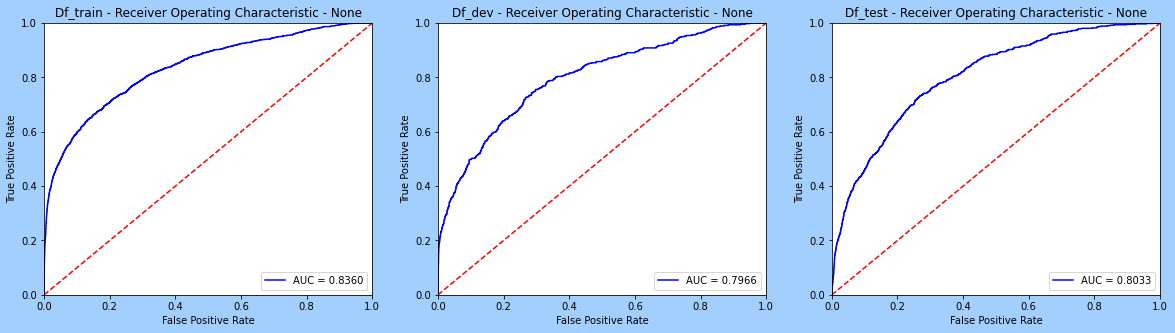

In [23]:
# Create model path
model_format = datetime.strftime(datetime.today(), "%Y%m%d_%H%M")
model_folder = f"{model_path}{model_format}_{model}_{model_type}_model/"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)

importance_lgbm = lgbmodel.feature_importance(importance_type="gain")
df_importance_lgbm = pd.DataFrame(
    {'column': list(df_train[vars_to_model].columns),
     'importance_gain': importance_lgbm})
df_importance_lgbm.sort_values('importance_gain', ascending=False, axis=0, inplace=True)
df_importance_lgbm['importance_gain'] = df_importance_lgbm['importance_gain'] / \
                                        df_importance_lgbm['importance_gain'].sum()
# Export variable importance
df_importance_lgbm.to_csv(model_folder + model_format + "_important_variables.csv", sep=";", decimal=".", index=False)

print(df_importance_lgbm.head(30))

export_auc_graph(df_train=df_train,
                 df_dev=df_dev,
                 df_test=df_test,
                 model=lgbmodel,
                 vars_to_model=vars_to_model,
                 target_var=target_var,
                 file_path=model_folder + model_format + "_auc.png",
                 multiclass=False)

In [24]:
# Export model performance
export_model_performance_lgbm(model=lgbmodel,
                              vars_to_include=vars_to_model,
                              target_var=target_var,
                              id_var=id_vars,
                              period_var=period_vars,
                              score_var=score_var,
                              df=df_train,
                              table_name="train",
                              model_folder=model_folder,
                              model_format=model_format,
                              export_df=False)
export_model_performance_lgbm(model=lgbmodel,
                              vars_to_include=vars_to_model,
                              target_var=target_var,
                              id_var=id_vars,
                              period_var=period_vars,
                              score_var=score_var,
                              df=df_dev,
                              table_name="dev",
                              model_folder=model_folder,
                              model_format=model_format,
                              export_df=False)

export_model_performance_lgbm(model=lgbmodel,
                              vars_to_include=vars_to_model,
                              target_var=target_var,
                              id_var=id_vars,
                              period_var=period_vars,
                              score_var=score_var,
                              df=df_test,
                              table_name="test",
                              model_folder=model_folder,
                              model_format=model_format,
                              export_df=True,
                              N=20)

df_explore = df_test.copy()
df_explore[score_var] = lgbmodel.predict(df_test[vars_to_model])

df_summary = variable_avg_by_ntile(df_explore,
                                   N=10,
                                   score_col=score_var,
                                   feature_importance=df_importance_lgbm)

df_summary.to_csv(model_folder + model_format + "_summary.csv", sep=";", decimal=",", index=False)

# Export volumes
df_volume = get_model_volumes(df_train=df_train,
                              df_dev=df_dev,
                              df_test=df_test,
                              period_var="DATE_CALC",
                              target_var=target_var)
df_volume.to_csv(model_folder + model_format + "_volumes.csv", sep=";", decimal=",", index=False)

# Save parameteres
save_json(model_parameters, model_folder + model_format + "_model_parameters.json")

df = []
vars_to_analyze = df_importance_lgbm[df_importance_lgbm["importance_gain"] > 0]["column"].values.tolist()

df_list = [df_train[period_vars + vars_to_analyze],
           df_dev[period_vars + vars_to_analyze],
           df_test[period_vars + vars_to_analyze]]
df = pd.concat(df_list)
df = df.groupby(period_vars).agg(np.nanmean).T.reset_index().rename(columns={"index": "column"})
df = pd.merge(df, df_importance_lgbm, on="column", how="inner")
df.to_csv(model_folder + model_format + "_mean_evolution.csv", sep=";", decimal=",")

# Calculate NaN evolution
df = []
vars_to_analyze = df_importance_lgbm[df_importance_lgbm["importance_gain"] > 0]["column"].values.tolist()

df_list = [df_train[period_vars + vars_to_analyze],
           df_dev[period_vars + vars_to_analyze],
           df_test[period_vars + vars_to_analyze]]
df = pd.concat(df_list)
df = df.groupby(period_vars).agg(lambda x: x.isnull().sum()/len(x)).T.reset_index().rename(columns={"index": "column"})
df = pd.merge(df, df_importance_lgbm, on="column", how="inner")
df.to_csv(model_folder + model_format + "_nan_evolution.csv", sep=";", decimal=",")

# Calculate NaNs by decile
df_explore = get_ntile(df_explore,
                       N=10,
                       score_col=score_var,
                       ntile_col="DECIL")

df_explore_grouped = df_explore[period_vars + vars_to_analyze + ["DECIL"]].groupby("DECIL").agg(lambda x: x.isnull().sum()/len(x)
                                                                                               ).T.reset_index(
                                                                                               ).rename(columns={"index": "column"})

df_explore_grouped = pd.merge(df_explore_grouped, df_importance_lgbm, on="column", how="inner")
df_explore_grouped.to_csv(model_folder + model_format + "_nan_summary.csv", sep=";", decimal=",")